In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2013
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2013-08-03,2013-08-04,9,Miscellaneous,10.934740,CDF,VOLCANO,"POLYGON ((-120.78865 38.98208, -120.78863 38.9..."
1,2013-08-09,2013-08-09,9,Miscellaneous,206.080700,USF,BEE,"POLYGON ((-118.45753 34.56763, -118.45755 34.5..."
2,2013-06-09,2013-06-09,2,Equipment Use,17.784730,USF,DEL,"POLYGON ((-118.75073 34.64511, -118.75080 34.6..."
3,2013-09-07,2013-09-09,9,Miscellaneous,5.024302,USF,GULCH,"POLYGON ((-118.49904 34.55759, -118.49913 34.5..."
4,2013-05-13,2013-05-14,10,Vehicle,49.124420,USF,HIGHWAY,"POLYGON ((-118.69682 34.58156, -118.69681 34.5..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2013-08-03,2013-08-04,9,Miscellaneous,10.934740
1,2013-08-09,2013-08-09,9,Miscellaneous,206.080700
2,2013-06-09,2013-06-09,2,Equipment Use,17.784730
3,2013-09-07,2013-09-09,9,Miscellaneous,5.024302
4,2013-05-13,2013-05-14,10,Vehicle,49.124420


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2013-08-03,2013-08-04,9,Miscellaneous,10.934740,1 days
1,2013-08-09,2013-08-09,9,Miscellaneous,206.080700,0 days
2,2013-06-09,2013-06-09,2,Equipment Use,17.784730,0 days
3,2013-09-07,2013-09-09,9,Miscellaneous,5.024302,2 days
4,2013-05-13,2013-05-14,10,Vehicle,49.124420,1 days


In [7]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,180,2013-08-13,2013-08-25,1,Lightning,0.755335,12 days
1,240,2013-05-14,2013-05-15,1,Lightning,8.425359,1 days
2,203,2013-07-24,2013-08-24,1,Lightning,14.367900,31 days
3,252,2013-05-04,2013-05-07,1,Lightning,15.359030,3 days
4,260,2013-09-10,2013-09-16,1,Lightning,0.079444,6 days


In [8]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,26.00,997.18,56
2,Equipment Use,1.53,138.83,34
3,Smoking,1.00,232.97,6
4,Campfire,14.80,17662.81,15
5,Debris,1.50,133.87,8
6,Railroad,0.00,17.30,2
7,Arson,12.33,5197.43,9
8,Playing with fire,0.00,41.23,4
9,Miscellaneous,16.70,2586.19,44


In [9]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2013.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,26.00,997.18,56
2,Equipment Use,1.53,138.83,34
3,Smoking,1.00,232.97,6
4,Campfire,14.80,17662.81,15
5,Debris,1.50,133.87,8
6,Railroad,0.00,17.30,2
7,Arson,12.33,5197.43,9
8,Playing with fire,0.00,41.23,4
10,Vehicle,0.92,100.82,12


In [10]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,38.87,24549.97,107
1,Natural,26.00,997.18,56


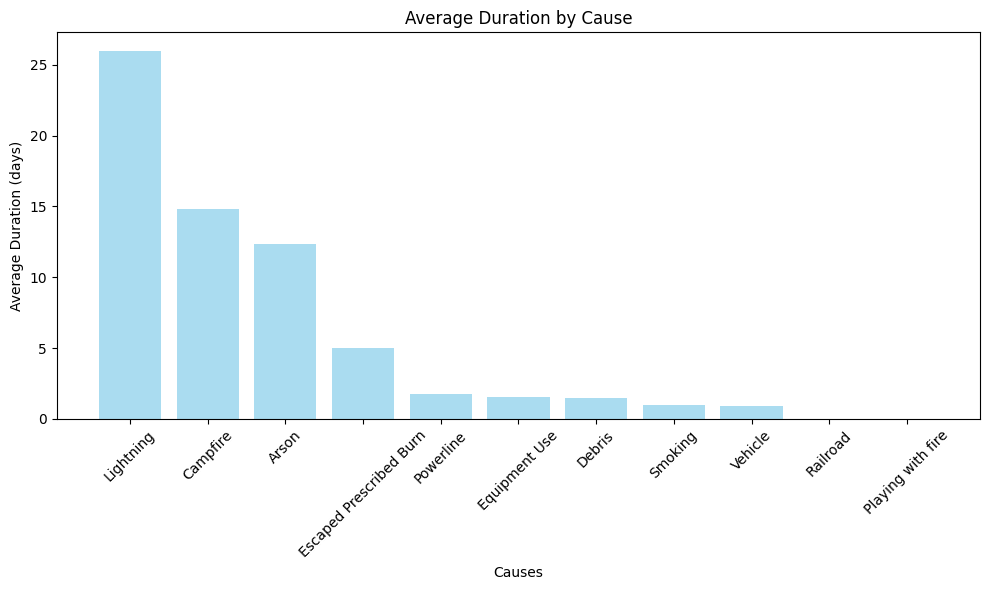

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

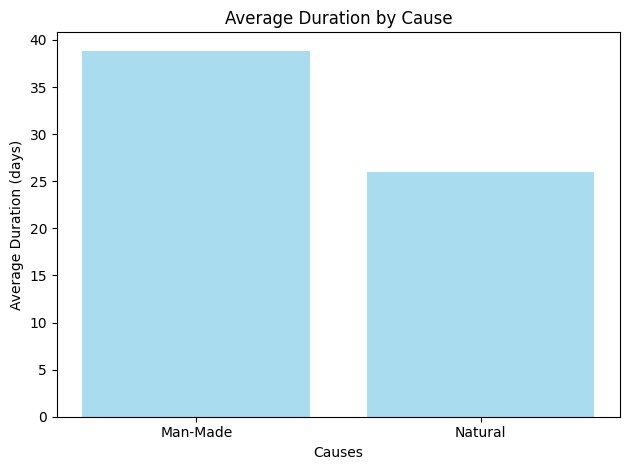

In [12]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

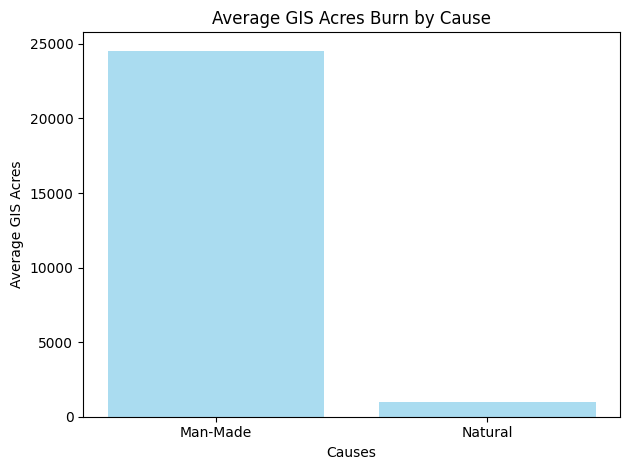

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

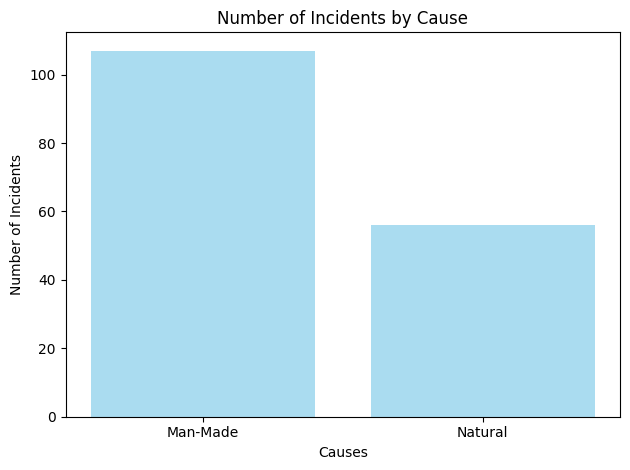

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

In [16]:
# Replace 'vehicle' and 'railroad' with 'transportation' in 'causes' column
fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad'], 'Transportation', inplace=True)

C:\Users\Long\AppData\Local\Temp\ipykernel_8344\3185232007.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad'], 'Transportation', inplace=True)


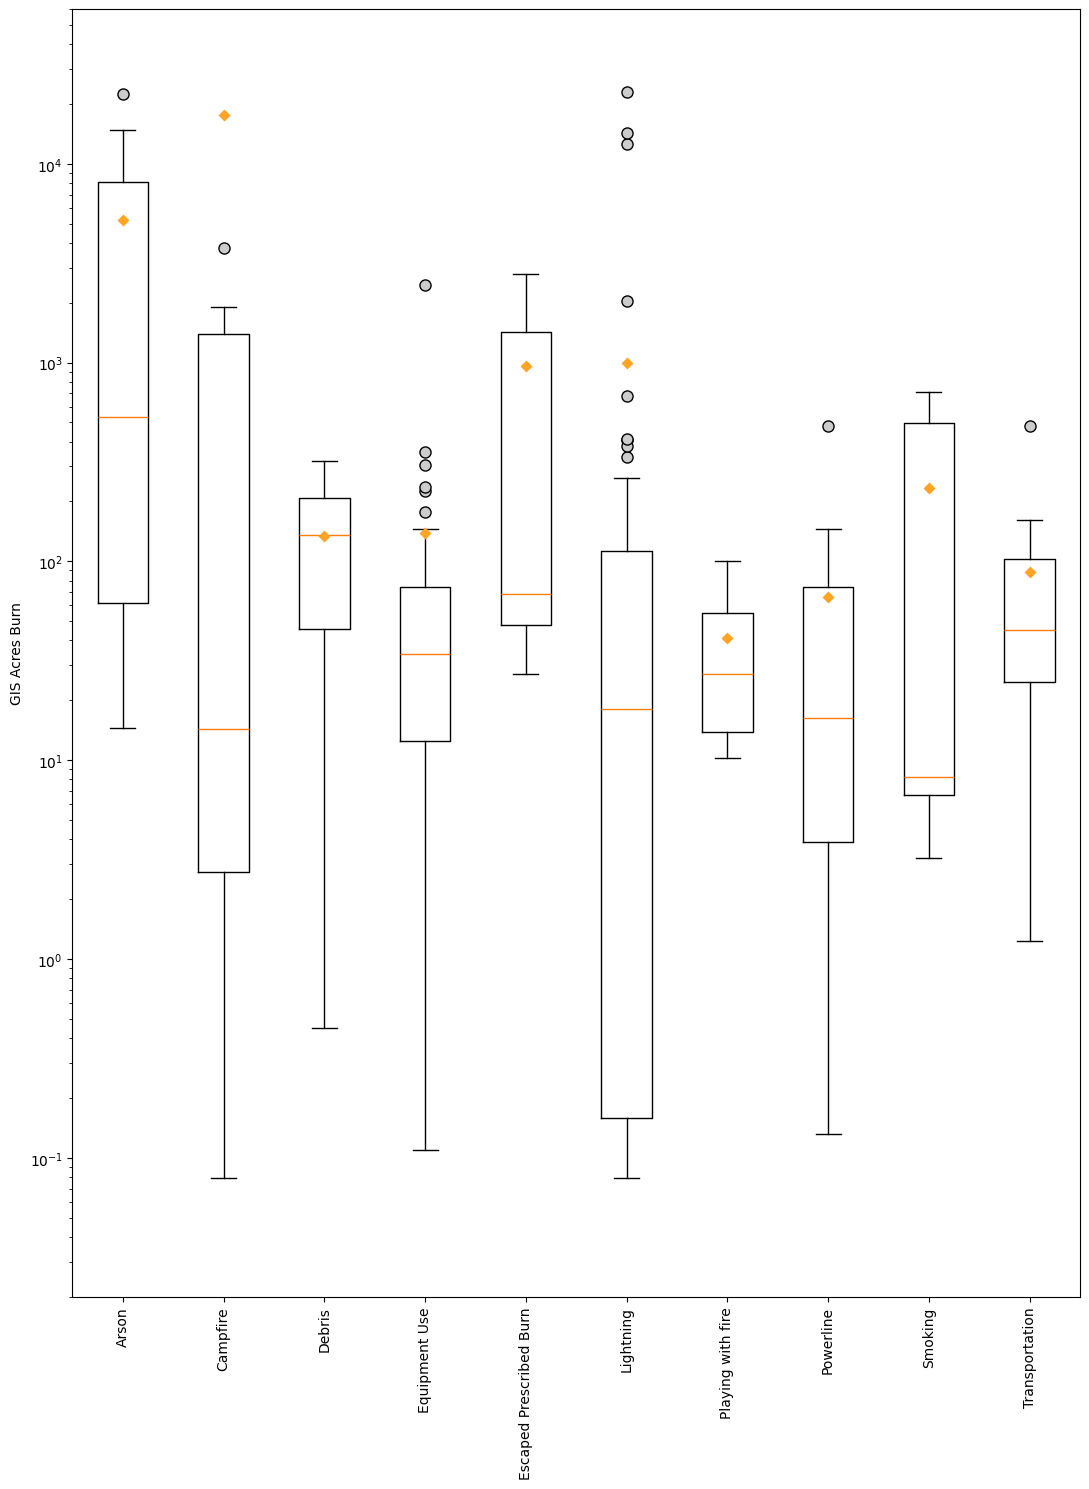

In [17]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.02, 60000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()